<a href="https://colab.research.google.com/github/helenatong/oc_p5_Segmentez_des_clients_d_un_site_e-commerce/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [ce fichier TO MOD](https://drive.google.com/file/d/1NWEnq2dD_kOGe-tnFS2w1-C7apQ1ejWx/view?usp=drive_link) dans Google Drive
- Modifier les chemins du fichier (extract_path) dans le code


---

 ## **Contexte et description du notebook**

---

## **Sommaire**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions et des variables globales**

### **III. Analyse exploratoire**

# **I. Installation et mise en place de l'environnement de travail**

In [283]:
# importation des librairies
import numpy as np
import pandas as pd
import sqlite3

import zipfile
import os

import re

import sys

import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

import datetime

In [284]:
# informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Seaborn       : 0.13.1
Run date      : 2024-06-17T18:05:46.905941


In [285]:
# configurations de l'affichages des donnees
# pd.set_option('display.max_columns', None)

In [286]:
# connexion au drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [287]:
# connecter la base de données
conn = sqlite3.connect('/content/drive/MyDrive/openclassrooms/project_list/project_5/data/olist.db')

tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
table_names = [table[0] for table in tables]

dfs = {}

for table_name in table_names:
    cursor = conn.execute(f"SELECT * FROM {table_name};")
    rows = cursor.fetchall()
    column_names = [description[0] for description in cursor.description]
    dfs[table_name] = pd.DataFrame(rows, columns=column_names).set_index('index')

    conn.commit()

for table_name, df in dfs.items():
  print(f"Table: {table_name}")

Table: customers
Table: geoloc
Table: order_items
Table: order_pymts
Table: order_reviews
Table: orders
Table: products
Table: sellers
Table: translation


In [288]:
# récupérer les dataframes
df_customers      = dfs.get('customers')
df_geoloc         = dfs.get('geoloc')
df_order_items    = dfs.get('order_items')
df_order_pymts    = dfs.get('order_pymts')
df_order_reviews  = dfs.get('order_reviews')
df_orders         = dfs.get('orders')
df_products       = dfs.get('products')
df_sellers        = dfs.get('sellers')
df_translation    = dfs.get('translation')

# vérifier l'importation
for table_name in dfs.keys():
  df = locals()[f'df_{table_name}']
  print(table_name, '\n', df.head(2), end='\n\n\n')

customers 
                             customer_id                customer_unique_id  \
index                                                                       
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   

       customer_zip_code_prefix          customer_city customer_state  
index                                                                  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  


geoloc 
        geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
index                                                                  
0                             1037       -23.545621       -46.639292   
1                             1046       -23.546081       -46.644820   

      geolocation_city geolocation_state  
index                                     
0    

#**II. EXPLORATION DU FICHIER**

**ORDRE DE GRANDEUR**

In [324]:
# informations principales
print(f"CA: {df_order_pymts['payment_value'].sum()}")
print(f"nb de client: {df_customers['customer_unique_id'].nunique()}")
print(f"CA/client: {((df_order_pymts['payment_value'].sum())/(df_customers['customer_unique_id'].nunique())).round(0)}\n")

print(f"nb total de commandes passées: {df_orders['order_id'].count()}")
print(f"nb total de commandes passées non annulées: {df_orders.loc[df_orders['order_status'] != 'canceled', 'order_id'].nunique()}")
print(f"% de commandes annulées: {((df_orders['order_id'].count())/(df_orders.loc[df_orders['order_status'] != 'canceled', 'order_id'].nunique())).round(2)}%")

df_temp = df_order_pymts.merge(df_orders, how = 'inner', on = ['order_id'])
print(f"montant de commandes annulées: {df_temp.loc[df_temp['order_status'] == 'canceled', 'payment_value'].sum()}")
print(f"% du CA total: {(100*(df_temp.loc[df_temp['order_status'] == 'canceled', 'payment_value'].sum())/((df_order_pymts['payment_value'].sum()))).round(2)}%")

CA: 16008872.12
nb de client: 96096
CA/client: 167.0

nb total de commandes passées: 99441
nb total de commandes passées non annulées: 98816
% de commandes annulées: 1.01%
montant de commandes annulées: 143255.6
% du CA total: 0.89%


In [290]:
# informations secondaires
print(f"nb de vendeurs: {df_sellers['seller_id'].nunique()}")
print(f"nb de références produits: {df_products['product_id'].nunique()}")

nb de vendeurs: 3095
nb de références produits: 32951


In [292]:
# informations temporelles
print(f"date de la dernière commande passée : {df_orders['order_purchase_timestamp'].max()}")
print(f"date de la première commande passée : {df_orders['order_purchase_timestamp'].min()}")

date de la dernière commande passée : 2018-10-17 17:30:18
date de la première commande passée : 2016-09-04 21:15:19


In [293]:
# le top 10 de ...
print(f"top 10 des montants les plus hauts: {df_order_pymts['payment_value'].sort_values(ascending=False).head(10)}")

# le top 10 des produits les plus vendus
#to do

top 10 des montants les plus hauts: index
52107    13664.08
34370     7274.88
41419     6929.31
49581     6922.21
85539     6726.66
62409     6081.54
43232     4950.34
70320     4809.44
6440      4764.34
67546     4681.78
Name: payment_value, dtype: float64


In [294]:
# df_customers
# df_geoloc
# df_order_items
# df_order_pymts
# df_order_reviews
# df_orders
# df_products
# df_sellers
# df_translation

In [295]:
print(df_translation['product_category_name'].unique().shape)
print(df_products['product_category_name'].unique().shape)

(71,)
(74,)


#**III. Création dataframe par client**

In [296]:
# créer le dataframe commun
mask = ['customer_id', 'customer_unique_id']
df = df_customers[mask].copy()

df = df.merge(df_orders, how = 'inner', on = ['customer_id'])

mask = ['order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']
df = df.merge(df_order_reviews[mask], on = ['order_id'], how = 'inner')

df = df.merge(df_order_pymts, on = ['order_id'], how = 'inner')

# mask = ['order_id', 'order_item_id', 'product_id']
# df = df.merge(df_order_items[mask], on = ['order_id'], how = 'inner')

# mask = ['product_id', 'product_category_name']
# df = df.merge(df_products[mask], on = ['product_id'], how = 'inner')

# df = df.merge(df_translation, on = ['product_category_name'], how = 'left') #s'il manque des traductions

In [297]:
df.dtypes

customer_id                       object
customer_unique_id                object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
review_score                       int64
review_creation_date              object
review_answer_timestamp           object
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
dtype: object

In [298]:
# convertir les dates et conserver uniquement l'année, le mois et le jour
date_variables = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp']

for var in date_variables:
  df[var] = pd.to_datetime(df[var], format='%Y-%m-%d %H:%M:%S')
  df[var] = df[var].dt.date

In [299]:
df['order_status'].value_counts
df['order_is_canceled'] = df['order_status'].apply(lambda x: 1 if x == 'canceled' else 0)

df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

df['nb_days_delivery_delay'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['delivered_late'] = df['nb_days_delivery_delay'].apply(lambda x: 1 if x < 0 else 0)
df

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_is_canceled,nb_days_delivery_delay,delivered_late
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,2017-05-23,2017-05-25,2017-06-05,4,2017-05-26,2017-05-30,1,credit_card,2,146.87,0,11.0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12,2018-01-15,2018-01-29,2018-02-06,5,2018-01-30,2018-02-10,1,credit_card,8,335.48,0,8.0,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20,2018-06-11,2018-06-14,2018-06-13,5,2018-06-15,2018-06-15,1,credit_card,7,157.73,0,-1.0,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13,2018-03-27,2018-03-28,2018-04-10,5,2018-03-29,2018-04-02,1,credit_card,1,173.30,0,13.0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29,2018-07-30,2018-08-09,2018-08-15,5,2018-08-10,2018-08-17,1,credit_card,8,252.25,0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103672,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07,2018-04-07,2018-04-11,2018-04-13,2018-04-25,4,2018-04-14,2018-04-28,1,credit_card,6,88.78,0,12.0,0
103673,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04,2018-04-04,2018-04-05,2018-04-11,2018-04-20,5,2018-04-12,2018-04-16,1,credit_card,3,129.06,0,9.0,0
103674,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08,2018-04-08,2018-04-09,2018-05-09,2018-05-02,1,2018-05-04,2018-05-08,1,credit_card,5,56.04,0,-7.0,1
103675,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03,2017-11-03,2017-11-06,2017-11-16,2017-12-05,5,2017-11-17,2017-11-19,1,credit_card,2,711.07,0,19.0,0


In [300]:
df

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_is_canceled,nb_days_delivery_delay,delivered_late
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,2017-05-23,2017-05-25,2017-06-05,4,2017-05-26,2017-05-30,1,credit_card,2,146.87,0,11.0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12,2018-01-15,2018-01-29,2018-02-06,5,2018-01-30,2018-02-10,1,credit_card,8,335.48,0,8.0,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20,2018-06-11,2018-06-14,2018-06-13,5,2018-06-15,2018-06-15,1,credit_card,7,157.73,0,-1.0,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13,2018-03-27,2018-03-28,2018-04-10,5,2018-03-29,2018-04-02,1,credit_card,1,173.30,0,13.0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29,2018-07-30,2018-08-09,2018-08-15,5,2018-08-10,2018-08-17,1,credit_card,8,252.25,0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103672,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07,2018-04-07,2018-04-11,2018-04-13,2018-04-25,4,2018-04-14,2018-04-28,1,credit_card,6,88.78,0,12.0,0
103673,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04,2018-04-04,2018-04-05,2018-04-11,2018-04-20,5,2018-04-12,2018-04-16,1,credit_card,3,129.06,0,9.0,0
103674,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08,2018-04-08,2018-04-09,2018-05-09,2018-05-02,1,2018-05-04,2018-05-08,1,credit_card,5,56.04,0,-7.0,1
103675,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03,2017-11-03,2017-11-06,2017-11-16,2017-12-05,5,2017-11-17,2017-11-19,1,credit_card,2,711.07,0,19.0,0


In [301]:
df.columns

Index(['customer_id', 'customer_unique_id', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_is_canceled',
       'nb_days_delivery_delay', 'delivered_late'],
      dtype='object')

In [302]:
# df['diff_estimated_delivered']
# df['tot_cost']

# Recence : last(order purshase)
# Fréquence : compter le nb de order id par client
# Montant : last(dépense par client)

# Feature engineering intéressant:
# retard de livraison order_estimated_delivery_date - order_delivered_customer_date
# score attribué moyen

# voir si granularité a l'item est bien

**DEMARCHE**

Dans la méthode RFM prend en compte la récence, la fréquence et le montant des achats d'un client.

Ici, je vais prendre en compte la date du dernier achat (récence), le nombre de commande passée (fréquence) et le montant total de tous les achats (montant) sur les 2 dernières années (2018-09-03 au 2016-09-04)

In [303]:
import datetime
# définir la date de référence
reference_date = datetime.datetime(2018, 9, 3)  # Utiliser datetime.datetime au lieu de datetime.date
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d')

# calculer la différence en jours
df['days_since_purchase'] = (reference_date - df['order_purchase_timestamp']).dt.days

In [304]:
df.describe()
#il manque ? order_delivered_customer_date

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,payment_sequential,payment_installments,payment_value,order_is_canceled,nb_days_delivery_delay,delivered_late,days_since_purchase
count,103677,100647,103677,103677.000000,103677.000000,103677.000000,103677.000000,103677.000000,100647.000000,103677.000000,103677.000000
mean,2017-12-29 01:46:33.518331136,2018-01-12 04:23:39.440221440,2018-01-22 12:17:15.446627328,4.083886,1.093685,2.854085,153.666237,0.006250,11.935825,0.064170,247.926001
min,2016-09-04 00:00:00,2016-10-11 00:00:00,2016-09-30 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,-188.000000,0.000000,-44.000000
25%,2017-09-09 00:00:00,2017-09-21 00:00:00,2017-09-29 00:00:00,4.000000,1.000000,1.000000,56.780000,0.000000,7.000000,0.000000,123.000000
50%,2018-01-17 00:00:00,2018-02-01 00:00:00,2018-02-14 00:00:00,5.000000,1.000000,1.000000,99.950000,0.000000,12.000000,0.000000,229.000000
75%,2018-05-03 00:00:00,2018-05-15 00:00:00,2018-05-25 00:00:00,5.000000,1.000000,4.000000,171.490000,0.000000,17.000000,0.000000,359.000000
max,2018-10-17 00:00:00,2018-10-17 00:00:00,2018-11-12 00:00:00,5.000000,29.000000,24.000000,13664.080000,1.000000,147.000000,1.000000,729.000000
std,NaN,NaN,NaN,1.349185,0.711547,2.687863,215.889863,0.078811,10.116939,0.245058,154.014645


In [305]:
df['order_delivered_customer_date'].unique()

<DatetimeArray>
['2017-05-25 00:00:00', '2018-01-29 00:00:00', '2018-06-14 00:00:00',
 '2018-03-28 00:00:00', '2018-08-09 00:00:00', '2017-09-28 00:00:00',
 '2018-02-20 00:00:00', '2017-11-27 00:00:00', '2018-01-26 00:00:00',
 '2018-01-13 00:00:00',
 ...
 '2018-07-29 00:00:00', '2016-11-05 00:00:00', '2017-05-14 00:00:00',
 '2016-10-22 00:00:00', '2017-02-27 00:00:00', '2017-08-20 00:00:00',
 '2018-09-25 00:00:00', '2016-11-28 00:00:00', '2017-02-19 00:00:00',
 '2017-10-29 00:00:00']
Length: 644, dtype: datetime64[ns]

In [306]:
df = df.groupby(by='customer_unique_id').agg(
        # last_order_date=('order_purchase_timestamp', 'min'),
        total_payment=('payment_value', 'sum'),
        days_since_purchase = ('days_since_purchase', 'min'),
        total_order=('order_id', 'count'),
        mean_review_score=('review_score', 'mean'),
        nb_order_canceled=('order_is_canceled', 'sum'),
        nb_order_delivered_late=('delivered_late', 'sum'),
        mean_nb_days_delivery_delay=('nb_days_delivery_delay', 'mean') #<0 = late
    ).reset_index()

In [307]:
df

,customer_unique_id,total_payment,days_since_purchase,total_order,mean_review_score,nb_order_canceled,nb_order_delivered_late,mean_nb_days_delivery_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,116,1,5.0,0,0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,119,1,4.0,0,0,5.0
2,0000f46a3911fa3c0805444483337064,86.22,542,1,3.0,0,0,2.0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,326,1,4.0,0,0,12.0
4,0004aac84e0df4da2b147fca70cf8255,196.89,293,1,5.0,0,0,8.0
...,...,...,...,...,...,...,...,...
95374,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,452,1,5.0,0,0,27.0
95375,fffea47cd6d3cc0a88bd621562a9d061,84.58,267,1,4.0,0,0,3.0
95376,ffff371b4d645b6ecea244b27531430a,112.46,573,1,5.0,0,0,30.0
95377,ffff5962728ec6157033ef9805bacc48,133.69,124,1,5.0,0,0,14.0


In [308]:
df.describe()

,total_payment,days_since_purchase,total_order,mean_review_score,nb_order_canceled,nb_order_delivered_late,mean_nb_days_delivery_delay
count,95379.000000,95379.000000,95379.000000,95379.000000,95379.000000,95379.000000,92752.000000
mean,167.035243,243.943929,1.087000,4.085023,0.006794,0.069753,11.886654
std,231.636162,153.420626,0.493834,1.341567,0.095814,0.272818,10.069831
min,0.000000,-44.000000,1.000000,1.000000,0.000000,0.000000,-188.000000
25%,63.120000,119.000000,1.000000,4.000000,0.000000,0.000000,7.000000
50%,108.020000,225.000000,1.000000,5.000000,0.000000,0.000000,12.000000
75%,183.865000,353.000000,1.000000,5.000000,0.000000,0.000000,17.000000
max,13664.080000,729.000000,33.000000,5.000000,9.000000,8.000000,147.000000


# **II. Transformation des variables**


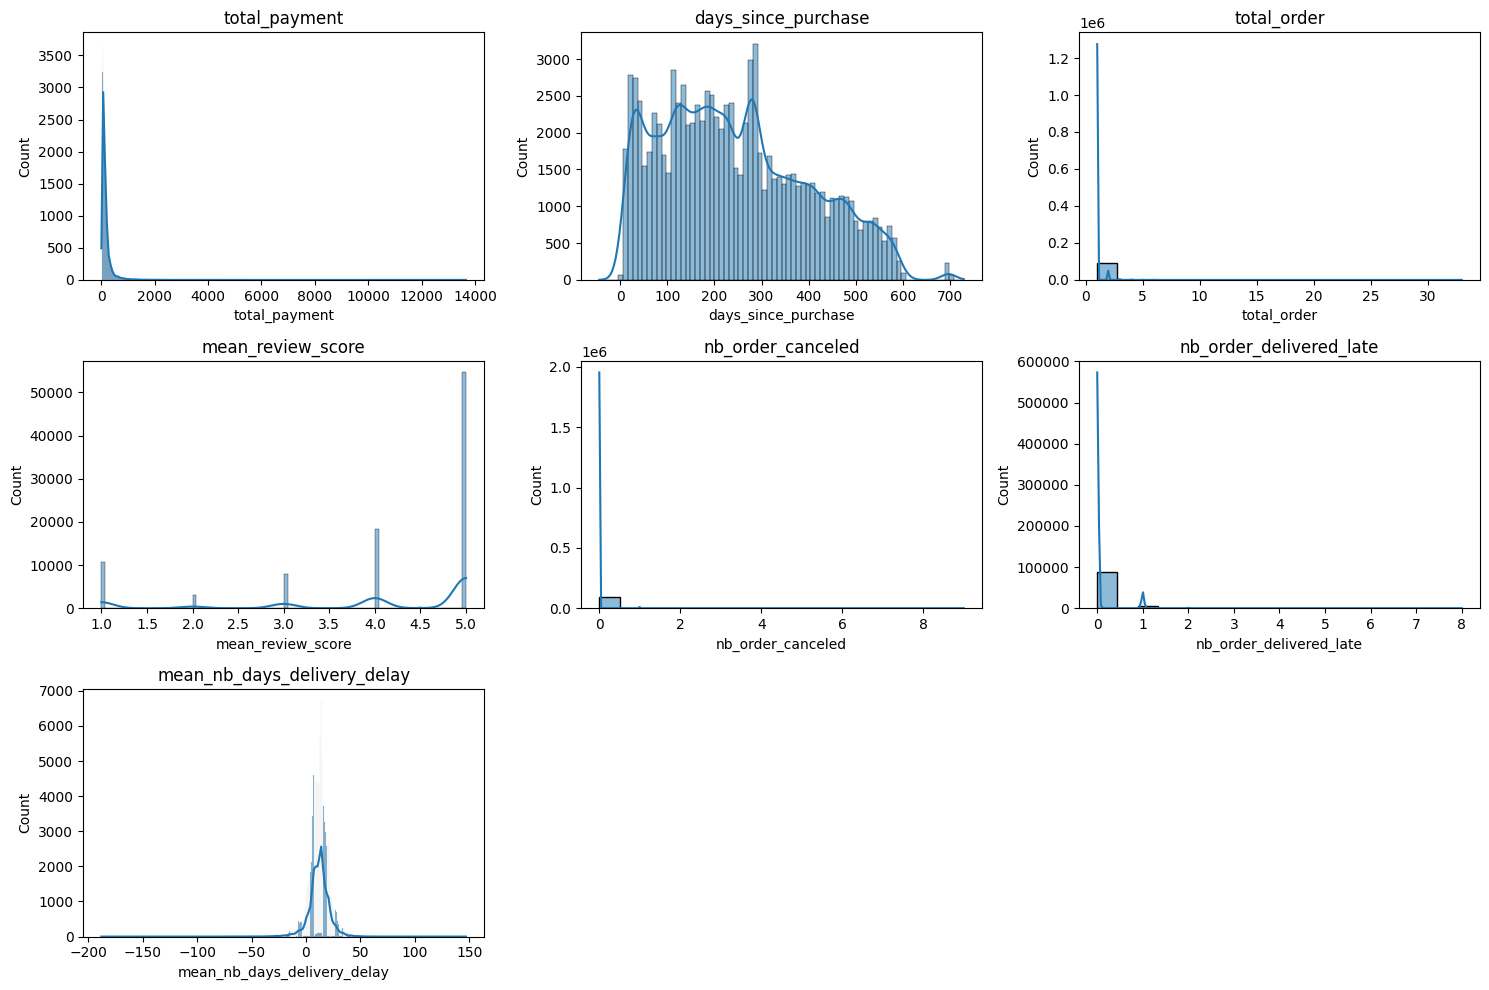

In [309]:
variables = [
    'total_payment', 'days_since_purchase', 'total_order',
    'mean_review_score', 'nb_order_canceled',
    'nb_order_delivered_late', 'mean_nb_days_delivery_delay'
]
plt.figure(figsize=(15, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[var], kde=True)
    plt.title(var)
plt.tight_layout()
plt.show()